# Collision Avoidance Controller Demo

This notebook demonstrates the `CollisionAvoidanceController` which implements COLREGs-compliant collision avoidance with virtual waypoint generation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Polygon
from scipy.integrate import solve_ivp

from colav_controllers import CollisionAvoidanceController

/home/mstolberger/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Controller Parameters

- `a`: Heading dynamics coefficient
- `v`: Ship velocity (m/s)
- `eta`: Controller gain (must be > 1)
- `tp`: Prescribed time for heading convergence (seconds)
- `Cs`: Safe distance from obstacle (m)
- `v1_buffer`: Buffer distance to offset V1 outward for extra clearance (m)

In [2]:
# Controller parameters
a = 1.0       # Heading dynamics coefficient
v = 2.0       # Ship velocity (m/s)
eta = 2.0     # Controller gain (eta > 1)
tp = 3.0      # Prescribed time (seconds)
Cs = 15.0     # Safe distance from obstacle (m)
v1_buffer = 0.0  # V1 buffer (m) - 0 means no buffer

controller = CollisionAvoidanceController(a=a, v=v, eta=eta, tp=tp, Cs=Cs, v1_buffer=v1_buffer)

print(f"Controller initialized")
print(f"Safety radius Cs: {Cs}m")
print(f"V1 buffer: {v1_buffer}m")

Controller initialized
Safety radius Cs: 15.0m
V1 buffer: 0.0m


## Scenario 1: Single Obstacle Avoidance

Ship starts heading toward an obstacle and must avoid it (starboard turn per COLREGs).

In [3]:
# Initial state: [x, y, psi]
x0, y0, psi0 = 0.0, 0.0, np.radians(30)  # Heading 30° (northeast)

# Obstacle position
ox, oy = 40.0, 25.0

print(f"Initial position: ({x0}, {y0})")
print(f"Initial heading: {np.degrees(psi0):.1f}°")
print(f"Obstacle at: ({ox}, {oy})")

Initial position: (0.0, 0.0)
Initial heading: 30.0°
Obstacle at: (40.0, 25.0)


In [4]:
#
 
S
e
t
 
v
i
r
t
u
a
l
 
w
a
y
p
o
i
n
t
 
(
V
1
)
 
b
a
s
e
d
 
o
n
 
o
b
s
t
a
c
l
e

o
b
s
t
a
c
l
e
 
=
 
[
(
o
x
,
 
o
y
,
 
0
.
0
,
 
0
.
0
)
]
 
 
#
 
(
x
,
 
y
,
 
v
e
l
o
c
i
t
y
,
 
h
e
a
d
i
n
g
)

c
o
n
t
r
o
l
l
e
r
.
s
e
t
_
v
i
r
t
u
a
l
_
w
a
y
p
o
i
n
t
_
d
y
n
a
m
i
c
(
x
0
,
 
y
0
,
 
p
s
i
0
,
 
o
b
s
t
a
c
l
e
)


v
1
 
=
 
c
o
n
t
r
o
l
l
e
r
.
v
i
r
t
u
a
l
_
w
a
y
p
o
i
n
t

p
r
i
n
t
(
f
"
V
i
r
t
u
a
l
 
w
a
y
p
o
i
n
t
 
V
1
:
 
(
{
v
1
[
0
]
:
.
2
f
}
,
 
{
v
1
[
1
]
:
.
2
f
}
)
"
)

SyntaxError: unterminated string literal (detected at line 213) (2341632682.py, line 213)

In [ ]:
# Simulation
t_span = (0, 25)
t_eval = np.linspace(0, 25, 500)

def dynamics(t, state):
    """ODE system for collision avoidance."""
    x, y, psi = state
    return controller.compute_dynamics(t, x, y, psi)

sol = solve_ivp(dynamics, t_span, [x0, y0, psi0], t_eval=t_eval, method='RK45')

print(f"Simulation complete: {len(sol.t)} time steps")

Simulation complete: 500 time steps


## Visualization

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


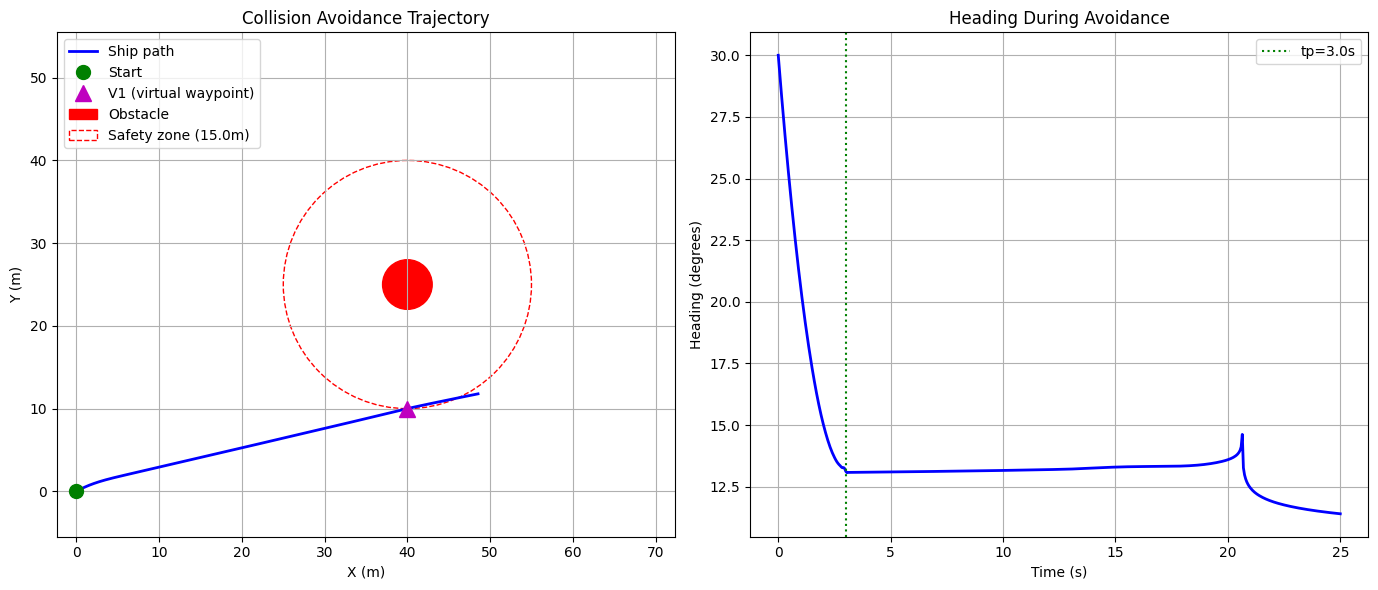

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Trajectory with obstacle
ax = axes[0]
ax.plot(sol.y[0], sol.y[1], 'b-', linewidth=2, label='Ship path')
ax.plot(x0, y0, 'go', markersize=10, label='Start')
ax.plot(v1[0], v1[1], 'm^', markersize=12, label='V1 (virtual waypoint)')

# Draw obstacle and safety zone
obstacle = Circle((ox, oy), 3, color='red', label='Obstacle')
safety_zone = Circle((ox, oy), Cs, color='red', fill=False, linestyle='--', label=f'Safety zone ({Cs}m)')
ax.add_patch(obstacle)
ax.add_patch(safety_zone)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Collision Avoidance Trajectory')
ax.legend(loc='upper left')
ax.grid(True)
ax.axis('equal')
ax.set_xlim(-10, 80)
ax.set_ylim(-10, 60)

# Plot 2: Heading over time
ax = axes[1]
psi_deg = np.degrees(sol.y[2])
ax.plot(sol.t, psi_deg, 'b-', linewidth=2)
ax.axvline(x=tp, color='g', linestyle=':', label=f'tp={tp}s')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Heading (degrees)')
ax.set_title('Heading During Avoidance')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

## Verify Collision Avoidance

Check minimum distance to obstacle during maneuver.

In [ ]:
# Calculate distance to obstacle over time
distances = np.sqrt((sol.y[0] - ox)**2 + (sol.y[1] - oy)**2)
min_distance = np.min(distances)
min_idx = np.argmin(distances)

print(f"Minimum distance to obstacle: {min_distance:.2f}m")
print(f"Safety margin Cs: {Cs}m")
print(f"Collision avoided: {min_distance >= Cs}")
print(f"Closest approach at t = {sol.t[min_idx]:.2f}s")

Minimum distance to obstacle: 14.66m
Safety margin Cs: 15.0m
Collision avoided: False
Closest approach at t = 22.19s


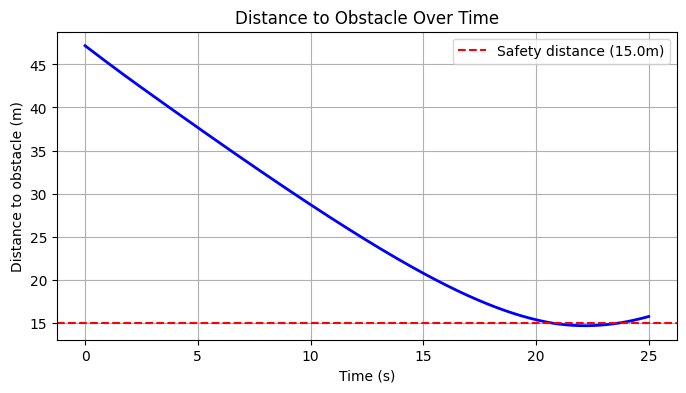

In [ ]:
# Plot distance over time
plt.figure(figsize=(8, 4))
plt.plot(sol.t, distances, 'b-', linewidth=2)
plt.axhline(y=Cs, color='r', linestyle='--', label=f'Safety distance ({Cs}m)')
plt.xlabel('Time (s)')
plt.ylabel('Distance to obstacle (m)')
plt.title('Distance to Obstacle Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Scenario 2: Multiple Obstacles (Dynamic Mode)

In [ ]:
# Reset controller
controller.reset()

# Multiple obstacles: (x, y, velocity, heading)
obstacles = [
    (30.0, 15.0, 0.0, 0.0),
    (50.0, 35.0, 0.0, 0.0),
]

# Set virtual waypoint for multiple obstacles
x0_2, y0_2, psi0_2 = 0.0, 0.0, np.radians(25)
controller.set_virtual_waypoint(x0_2, y0_2, psi0_2, obstacles)

v1_multi = controller.virtual_waypoint
print(f"Virtual waypoint V1: ({v1_multi[0]:.2f}, {v1_multi[1]:.2f})")

Virtual waypoint V1: (30.00, 0.00)


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


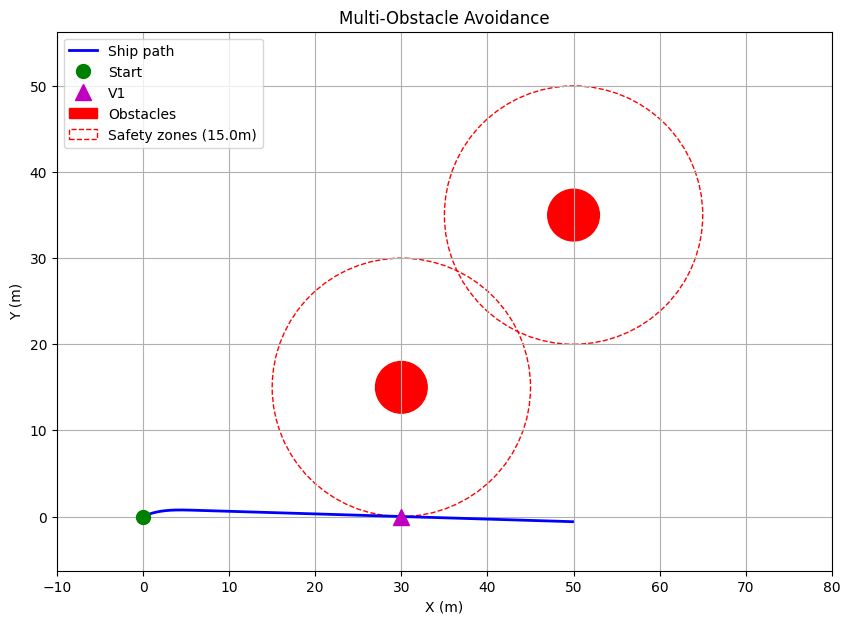

In [ ]:
# Simulate
sol2 = solve_ivp(dynamics, t_span, [x0_2, y0_2, psi0_2], t_eval=t_eval, method='RK45')

# Visualize
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(sol2.y[0], sol2.y[1], 'b-', linewidth=2, label='Ship path')
ax.plot(x0_2, y0_2, 'go', markersize=10, label='Start')
ax.plot(v1_multi[0], v1_multi[1], 'm^', markersize=12, label='V1')

# Draw obstacles
for i, (ox_i, oy_i, _, _) in enumerate(obstacles):
    obstacle = Circle((ox_i, oy_i), 3, color='red')
    safety_zone = Circle((ox_i, oy_i), Cs, color='red', fill=False, linestyle='--')
    ax.add_patch(obstacle)
    ax.add_patch(safety_zone)
    if i == 0:
        obstacle.set_label('Obstacles')
        safety_zone.set_label(f'Safety zones ({Cs}m)')

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Multi-Obstacle Avoidance')
ax.legend()
ax.grid(True)
ax.axis('equal')
ax.set_xlim(-10, 80)
ax.set_ylim(-10, 60)

plt.show()

## Scenario 3: Using V1 Buffer

Demonstrate the `v1_buffer` parameter which offsets V1 outward for extra clearance.

In [ ]:
#
 
C
r
e
a
t
e
 
c
o
n
t
r
o
l
l
e
r
 
w
i
t
h
 
b
u
f
f
e
r

c
o
n
t
r
o
l
l
e
r
_
b
u
f
f
e
r
e
d
 
=
 
C
o
l
l
i
s
i
o
n
A
v
o
i
d
a
n
c
e
C
o
n
t
r
o
l
l
e
r
(

 
 
 
 
a
=
a
,
 
v
=
v
,
 
e
t
a
=
e
t
a
,
 
t
p
=
t
p
,
 
C
s
=
C
s
,
 

 
 
 
 
v
1
_
b
u
f
f
e
r
=
5
.
0
 
 
#
 
5
 
m
e
t
e
r
 
b
u
f
f
e
r

)


#
 
S
a
m
e
 
i
n
i
t
i
a
l
 
c
o
n
d
i
t
i
o
n
s
 
a
s
 
S
c
e
n
a
r
i
o
 
1

x
0
_
3
,
 
y
0
_
3
,
 
p
s
i
0
_
3
 
=
 
0
.
0
,
 
0
.
0
,
 
n
p
.
r
a
d
i
a
n
s
(
3
0
)

o
x
_
3
,
 
o
y
_
3
 
=
 
4
0
.
0
,
 
2
5
.
0

o
b
s
t
a
c
l
e
_
3
 
=
 
[
(
o
x
_
3
,
 
o
y
_
3
,
 
0
.
0
,
 
0
.
0
)
]


#
 
C
o
m
p
u
t
e
 
V
1
 
w
i
t
h
o
u
t
 
b
u
f
f
e
r

c
o
n
t
r
o
l
l
e
r
.
r
e
s
e
t
(
)

c
o
n
t
r
o
l
l
e
r
.
s
e
t
_
v
i
r
t
u
a
l
_
w
a
y
p
o
i
n
t
_
d
y
n
a
m
i
c
(
x
0
_
3
,
 
y
0
_
3
,
 
p
s
i
0
_
3
,
 
o
b
s
t
a
c
l
e
_
3
)

v
1
_
n
o
_
b
u
f
f
e
r
 
=
 
c
o
n
t
r
o
l
l
e
r
.
v
i
r
t
u
a
l
_
w
a
y
p
o
i
n
t


#
 
C
o
m
p
u
t
e
 
V
1
 
w
i
t
h
 
b
u
f
f
e
r

c
o
n
t
r
o
l
l
e
r
_
b
u
f
f
e
r
e
d
.
s
e
t
_
v
i
r
t
u
a
l
_
w
a
y
p
o
i
n
t
_
d
y
n
a
m
i
c
(
x
0
_
3
,
 
y
0
_
3
,
 
p
s
i
0
_
3
,
 
o
b
s
t
a
c
l
e
_
3
)

v
1
_
w
i
t
h
_
b
u
f
f
e
r
 
=
 
c
o
n
t
r
o
l
l
e
r
_
b
u
f
f
e
r
e
d
.
v
i
r
t
u
a
l
_
w
a
y
p
o
i
n
t


p
r
i
n
t
(
f
"
V
1
 
w
i
t
h
o
u
t
 
b
u
f
f
e
r
:
 
(
{
v
1
_
n
o
_
b
u
f
f
e
r
[
0
]
:
.
2
f
}
,
 
{
v
1
_
n
o
_
b
u
f
f
e
r
[
1
]
:
.
2
f
}
)
"
)

p
r
i
n
t
(
f
"
V
1
 
w
i
t
h
 
5
m
 
b
u
f
f
e
r
:
 
(
{
v
1
_
w
i
t
h
_
b
u
f
f
e
r
[
0
]
:
.
2
f
}
,
 
{
v
1
_
w
i
t
h
_
b
u
f
f
e
r
[
1
]
:
.
2
f
}
)
"
)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


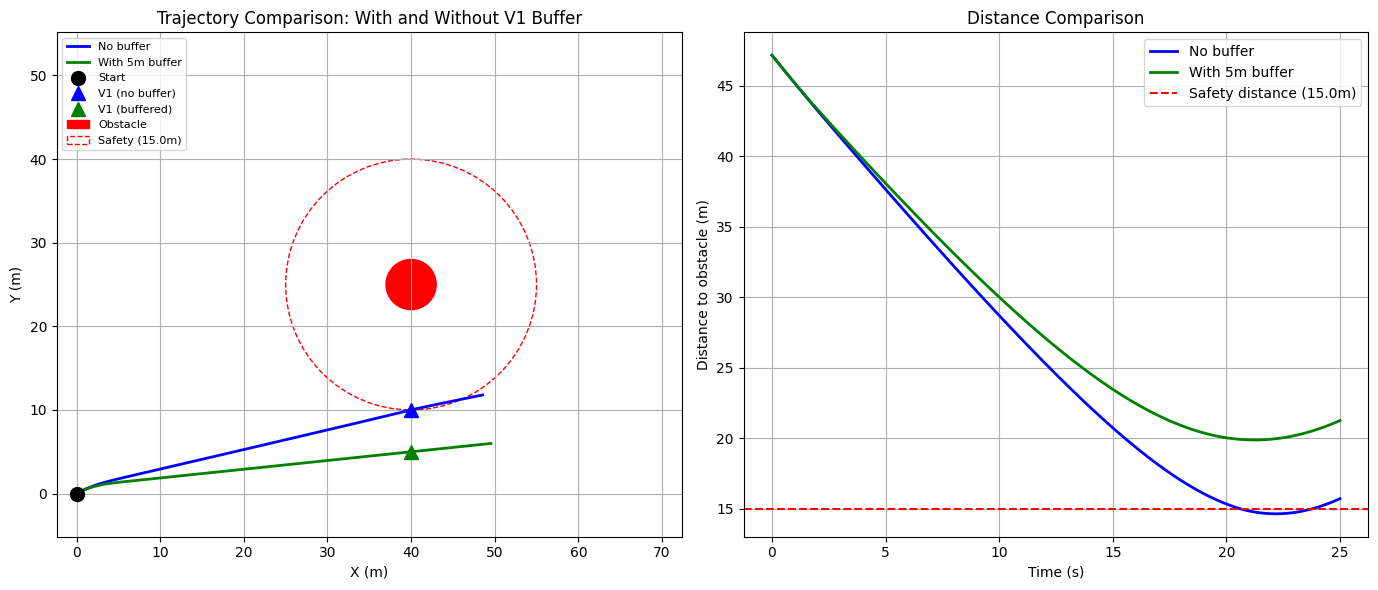

Min distance (no buffer): 14.66m
Min distance (with buffer): 19.89m
Extra clearance: 5.23m


In [ ]:
# Simulate both trajectories
def dynamics_buffered(t, state):
    x, y, psi = state
    return controller_buffered.compute_dynamics(t, x, y, psi)

sol_no_buffer = solve_ivp(dynamics, t_span, [x0_3, y0_3, psi0_3], t_eval=t_eval, method='RK45')
sol_with_buffer = solve_ivp(dynamics_buffered, t_span, [x0_3, y0_3, psi0_3], t_eval=t_eval, method='RK45')

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Trajectories
ax = axes[0]
ax.plot(sol_no_buffer.y[0], sol_no_buffer.y[1], 'b-', linewidth=2, label='No buffer')
ax.plot(sol_with_buffer.y[0], sol_with_buffer.y[1], 'g-', linewidth=2, label='With 5m buffer')
ax.plot(x0_3, y0_3, 'ko', markersize=10, label='Start')
ax.plot(v1_no_buffer[0], v1_no_buffer[1], 'b^', markersize=10, label='V1 (no buffer)')
ax.plot(v1_with_buffer[0], v1_with_buffer[1], 'g^', markersize=10, label='V1 (buffered)')

# Draw obstacle
obstacle = Circle((ox_3, oy_3), 3, color='red', label='Obstacle')
safety_zone = Circle((ox_3, oy_3), Cs, color='red', fill=False, linestyle='--', label=f'Safety ({Cs}m)')
ax.add_patch(obstacle)
ax.add_patch(safety_zone)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Trajectory Comparison: With and Without V1 Buffer')
ax.legend(loc='upper left', fontsize=8)
ax.grid(True)
ax.axis('equal')
ax.set_xlim(-10, 80)
ax.set_ylim(-10, 60)

# Plot 2: Distance comparison
ax = axes[1]
dist_no_buffer = np.sqrt((sol_no_buffer.y[0] - ox_3)**2 + (sol_no_buffer.y[1] - oy_3)**2)
dist_with_buffer = np.sqrt((sol_with_buffer.y[0] - ox_3)**2 + (sol_with_buffer.y[1] - oy_3)**2)

ax.plot(sol_no_buffer.t, dist_no_buffer, 'b-', linewidth=2, label='No buffer')
ax.plot(sol_with_buffer.t, dist_with_buffer, 'g-', linewidth=2, label='With 5m buffer')
ax.axhline(y=Cs, color='r', linestyle='--', label=f'Safety distance ({Cs}m)')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance to obstacle (m)')
ax.set_title('Distance Comparison')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

print(f"Min distance (no buffer): {np.min(dist_no_buffer):.2f}m")
print(f"Min distance (with buffer): {np.min(dist_with_buffer):.2f}m")
print(f"Extra clearance: {np.min(dist_with_buffer) - np.min(dist_no_buffer):.2f}m")

## Custom Vertex Provider

Demonstrate using a custom vertex provider for different unsafe set shapes.

In [ ]:
def square_vertex_provider(pos_x, pos_y, obstacles_list, Cs, psi):
    """
    Custom vertex provider that creates square unsafe sets.
    
    Args:
        pos_x, pos_y: Ship position
        obstacles_list: List of (ox, oy, ov, o_psi) tuples
        Cs: Safety distance
        psi: Ship heading
    
    Returns:
        List of vertices forming square unsafe sets
    """
    if not obstacles_list:
        return None
    
    vertices = []
    for ox, oy, _, _ in obstacles_list:
        # Create square vertices
        vertices.extend([
            (ox + Cs, oy + Cs),   # Top right
            (ox - Cs, oy + Cs),   # Top left
            (ox - Cs, oy - Cs),   # Bottom left
            (ox + Cs, oy - Cs),   # Bottom right
        ])
    
    return vertices if vertices else None

# Create controller with custom vertex provider
controller_custom = CollisionAvoidanceController(
    a=a, v=v, eta=eta, tp=tp, Cs=Cs,
    vertex_provider=square_vertex_provider
)

print("Controller with square vertex provider created")

Controller with square vertex provider created


In [ ]:
#
 
T
e
s
t
 
w
i
t
h
 
s
i
n
g
l
e
 
o
b
s
t
a
c
l
e

x
0
_
4
,
 
y
0
_
4
,
 
p
s
i
0
_
4
 
=
 
0
.
0
,
 
0
.
0
,
 
n
p
.
r
a
d
i
a
n
s
(
3
0
)

o
x
_
4
,
 
o
y
_
4
 
=
 
4
0
.
0
,
 
2
5
.
0

o
b
s
t
a
c
l
e
_
4
 
=
 
[
(
o
x
_
4
,
 
o
y
_
4
,
 
0
.
0
,
 
0
.
0
)
]


c
o
n
t
r
o
l
l
e
r
_
c
u
s
t
o
m
.
s
e
t
_
v
i
r
t
u
a
l
_
w
a
y
p
o
i
n
t
_
d
y
n
a
m
i
c
(
x
0
_
4
,
 
y
0
_
4
,
 
p
s
i
0
_
4
,
 
o
b
s
t
a
c
l
e
_
4
)

v
1
_
c
u
s
t
o
m
 
=
 
c
o
n
t
r
o
l
l
e
r
_
c
u
s
t
o
m
.
v
i
r
t
u
a
l
_
w
a
y
p
o
i
n
t


#
 
G
e
t
 
v
e
r
t
i
c
e
s
 
f
o
r
 
v
i
s
u
a
l
i
z
a
t
i
o
n

v
e
r
t
i
c
e
s
_
c
i
r
c
u
l
a
r
 
=
 
c
o
n
t
r
o
l
l
e
r
.
v
e
r
t
e
x
_
p
r
o
v
i
d
e
r
(
x
0
_
4
,
 
y
0
_
4
,
 
o
b
s
t
a
c
l
e
_
4
,
 
C
s
,
 
p
s
i
0
_
4
)

v
e
r
t
i
c
e
s
_
s
q
u
a
r
e
 
=
 
s
q
u
a
r
e
_
v
e
r
t
e
x
_
p
r
o
v
i
d
e
r
(
x
0
_
4
,
 
y
0
_
4
,
 
o
b
s
t
a
c
l
e
_
4
,
 
C
s
,
 
p
s
i
0
_
4
)


#
 
V
i
s
u
a
l
i
z
e
 
u
n
s
a
f
e
 
s
e
t
s

f
i
g
,
 
a
x
 
=
 
p
l
t
.
s
u
b
p
l
o
t
s
(
f
i
g
s
i
z
e
=
(
1
0
,
 
8
)
)


#
 
D
r
a
w
 
c
i
r
c
u
l
a
r
 
u
n
s
a
f
e
 
s
e
t
 
v
e
r
t
i
c
e
s

i
f
 
v
e
r
t
i
c
e
s
_
c
i
r
c
u
l
a
r
:

 
 
 
 
v
x
,
 
v
y
 
=
 
z
i
p
(
*
v
e
r
t
i
c
e
s
_
c
i
r
c
u
l
a
r
)

 
 
 
 
a
x
.
p
l
o
t
(
v
x
,
 
v
y
,
 
'
b
o
'
,
 
m
a
r
k
e
r
s
i
z
e
=
6
,
 
l
a
b
e
l
=
'
C
i
r
c
u
l
a
r
 
v
e
r
t
i
c
e
s
 
(
d
e
f
a
u
l
t
)
'
)


#
 
D
r
a
w
 
s
q
u
a
r
e
 
u
n
s
a
f
e
 
s
e
t
 
v
e
r
t
i
c
e
s

i
f
 
v
e
r
t
i
c
e
s
_
s
q
u
a
r
e
:

 
 
 
 
v
x
_
s
q
,
 
v
y
_
s
q
 
=
 
z
i
p
(
*
v
e
r
t
i
c
e
s
_
s
q
u
a
r
e
)

 
 
 
 
a
x
.
p
l
o
t
(
v
x
_
s
q
,
 
v
y
_
s
q
,
 
'
r
s
'
,
 
m
a
r
k
e
r
s
i
z
e
=
8
,
 
l
a
b
e
l
=
'
S
q
u
a
r
e
 
v
e
r
t
i
c
e
s
 
(
c
u
s
t
o
m
)
'
)

 
 
 
 
#
 
D
r
a
w
 
s
q
u
a
r
e
 
p
o
l
y
g
o
n

 
 
 
 
s
q
u
a
r
e
_
p
o
l
y
 
=
 
P
o
l
y
g
o
n
(
v
e
r
t
i
c
e
s
_
s
q
u
a
r
e
,
 
f
i
l
l
=
F
a
l
s
e
,
 
e
d
g
e
c
o
l
o
r
=
'
r
e
d
'
,
 
l
i
n
e
w
i
d
t
h
=
2
,
 
l
i
n
e
s
t
y
l
e
=
'
-
-
'
)

 
 
 
 
a
x
.
a
d
d
_
p
a
t
c
h
(
s
q
u
a
r
e
_
p
o
l
y
)


#
 
D
r
a
w
 
o
b
s
t
a
c
l
e

o
b
s
t
a
c
l
e
 
=
 
C
i
r
c
l
e
(
(
o
x
_
4
,
 
o
y
_
4
)
,
 
3
,
 
c
o
l
o
r
=
'
r
e
d
'
,
 
l
a
b
e
l
=
'
O
b
s
t
a
c
l
e
'
)

a
x
.
a
d
d
_
p
a
t
c
h
(
o
b
s
t
a
c
l
e
)


#
 
D
r
a
w
 
s
h
i
p
 
p
o
s
i
t
i
o
n
 
a
n
d
 
h
e
a
d
i
n
g

a
x
.
p
l
o
t
(
x
0
_
4
,
 
y
0
_
4
,
 
'
g
o
'
,
 
m
a
r
k
e
r
s
i
z
e
=
1
2
,
 
l
a
b
e
l
=
'
S
h
i
p
'
)

a
x
.
a
r
r
o
w
(
x
0
_
4
,
 
y
0
_
4
,
 
1
0
*
n
p
.
c
o
s
(
p
s
i
0
_
4
)
,
 
1
0
*
n
p
.
s
i
n
(
p
s
i
0
_
4
)
,
 

 
 
 
 
 
 
 
 
 
h
e
a
d
_
w
i
d
t
h
=
2
,
 
h
e
a
d
_
l
e
n
g
t
h
=
2
,
 
f
c
=
'
g
r
e
e
n
'
,
 
e
c
=
'
g
r
e
e
n
'
)


a
x
.
p
l
o
t
(
v
1
_
c
u
s
t
o
m
[
0
]
,
 
v
1
_
c
u
s
t
o
m
[
1
]
,
 
'
m
^
'
,
 
m
a
r
k
e
r
s
i
z
e
=
1
2
,
 
l
a
b
e
l
=
'
V
1
 
(
s
q
u
a
r
e
)
'
)


a
x
.
s
e
t
_
x
l
a
b
e
l
(
'
X
 
(
m
)
'
)

a
x
.
s
e
t
_
y
l
a
b
e
l
(
'
Y
 
(
m
)
'
)

a
x
.
s
e
t
_
t
i
t
l
e
(
'
U
n
s
a
f
e
 
S
e
t
 
C
o
m
p
a
r
i
s
o
n
:
 
C
i
r
c
u
l
a
r
 
v
s
 
S
q
u
a
r
e
'
)

a
x
.
l
e
g
e
n
d
(
)

a
x
.
g
r
i
d
(
T
r
u
e
)

a
x
.
a
x
i
s
(
'
e
q
u
a
l
'
)

a
x
.
s
e
t
_
x
l
i
m
(
-
5
,
 
6
5
)

a
x
.
s
e
t
_
y
l
i
m
(
-
5
,
 
5
0
)


p
l
t
.
s
h
o
w
(
)

## Scenario 4: Constant Heading Mode

After avoidance, the ship can maintain constant heading using `compute_constant_dynamics()`.

In [ ]:
#
 
F
i
r
s
t
:
 
a
v
o
i
d
 
o
b
s
t
a
c
l
e
 
(
u
s
e
 
r
e
s
u
l
t
 
f
r
o
m
 
S
c
e
n
a
r
i
o
 
1
)

#
 
T
h
e
n
:
 
s
w
i
t
c
h
 
t
o
 
c
o
n
s
t
a
n
t
 
h
e
a
d
i
n
g
 
m
o
d
e


#
 
R
e
s
e
t
 
a
n
d
 
s
e
t
 
u
p

c
o
n
t
r
o
l
l
e
r
.
r
e
s
e
t
(
)

c
o
n
t
r
o
l
l
e
r
.
s
e
t
_
v
i
r
t
u
a
l
_
w
a
y
p
o
i
n
t
_
d
y
n
a
m
i
c
(
0
.
0
,
 
0
.
0
,
 
n
p
.
r
a
d
i
a
n
s
(
3
0
)
,
 
[
(
4
0
.
0
,
 
2
5
.
0
,
 
0
.
0
,
 
0
.
0
)
]
)


#
 
P
h
a
s
e
 
1
:
 
A
v
o
i
d
a
n
c
e
 
(
0
 
t
o
 
1
5
s
)

t
_
a
v
o
i
d
 
=
 
(
0
,
 
1
5
)

s
o
l
_
a
v
o
i
d
 
=
 
s
o
l
v
e
_
i
v
p
(
d
y
n
a
m
i
c
s
,
 
t
_
a
v
o
i
d
,
 
[
0
.
0
,
 
0
.
0
,
 
n
p
.
r
a
d
i
a
n
s
(
3
0
)
]
,
 

 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
t
_
e
v
a
l
=
n
p
.
l
i
n
s
p
a
c
e
(
0
,
 
1
5
,
 
3
0
0
)
,
 
m
e
t
h
o
d
=
'
R
K
4
5
'
)


#
 
P
h
a
s
e
 
2
:
 
C
o
n
s
t
a
n
t
 
h
e
a
d
i
n
g
 
(
1
5
 
t
o
 
3
0
s
)

f
i
n
a
l
_
s
t
a
t
e
 
=
 
s
o
l
_
a
v
o
i
d
.
y
[
:
,
 
-
1
]


d
e
f
 
d
y
n
a
m
i
c
s
_
c
o
n
s
t
a
n
t
(
t
,
 
s
t
a
t
e
)
:

 
 
 
 
x
,
 
y
,
 
p
s
i
 
=
 
s
t
a
t
e

 
 
 
 
r
e
t
u
r
n
 
c
o
n
t
r
o
l
l
e
r
.
c
o
m
p
u
t
e
_
c
o
n
s
t
a
n
t
_
d
y
n
a
m
i
c
s
(
x
,
 
y
,
 
p
s
i
)


t
_
c
o
n
s
t
a
n
t
 
=
 
(
0
,
 
1
5
)

s
o
l
_
c
o
n
s
t
a
n
t
 
=
 
s
o
l
v
e
_
i
v
p
(
d
y
n
a
m
i
c
s
_
c
o
n
s
t
a
n
t
,
 
t
_
c
o
n
s
t
a
n
t
,
 
f
i
n
a
l
_
s
t
a
t
e
,

 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
t
_
e
v
a
l
=
n
p
.
l
i
n
s
p
a
c
e
(
0
,
 
1
5
,
 
3
0
0
)
,
 
m
e
t
h
o
d
=
'
R
K
4
5
'
)


#
 
C
o
m
b
i
n
e
 
t
r
a
j
e
c
t
o
r
i
e
s

c
o
m
b
i
n
e
d
_
x
 
=
 
n
p
.
c
o
n
c
a
t
e
n
a
t
e
(
[
s
o
l
_
a
v
o
i
d
.
y
[
0
]
,
 
s
o
l
_
c
o
n
s
t
a
n
t
.
y
[
0
]
]
)

c
o
m
b
i
n
e
d
_
y
 
=
 
n
p
.
c
o
n
c
a
t
e
n
a
t
e
(
[
s
o
l
_
a
v
o
i
d
.
y
[
1
]
,
 
s
o
l
_
c
o
n
s
t
a
n
t
.
y
[
1
]
]
)

c
o
m
b
i
n
e
d
_
p
s
i
 
=
 
n
p
.
c
o
n
c
a
t
e
n
a
t
e
(
[
s
o
l
_
a
v
o
i
d
.
y
[
2
]
,
 
s
o
l
_
c
o
n
s
t
a
n
t
.
y
[
2
]
]
)

c
o
m
b
i
n
e
d
_
t
 
=
 
n
p
.
c
o
n
c
a
t
e
n
a
t
e
(
[
s
o
l
_
a
v
o
i
d
.
t
,
 
s
o
l
_
c
o
n
s
t
a
n
t
.
t
 
+
 
1
5
]
)


#
 
P
l
o
t

f
i
g
,
 
a
x
e
s
 
=
 
p
l
t
.
s
u
b
p
l
o
t
s
(
1
,
 
2
,
 
f
i
g
s
i
z
e
=
(
1
4
,
 
6
)
)


#
 
T
r
a
j
e
c
t
o
r
y

a
x
 
=
 
a
x
e
s
[
0
]

a
x
.
p
l
o
t
(
c
o
m
b
i
n
e
d
_
x
[
:
3
0
0
]
,
 
c
o
m
b
i
n
e
d
_
y
[
:
3
0
0
]
,
 
'
b
-
'
,
 
l
i
n
e
w
i
d
t
h
=
2
,
 
l
a
b
e
l
=
'
A
v
o
i
d
a
n
c
e
 
p
h
a
s
e
'
)

a
x
.
p
l
o
t
(
c
o
m
b
i
n
e
d
_
x
[
3
0
0
:
]
,
 
c
o
m
b
i
n
e
d
_
y
[
3
0
0
:
]
,
 
'
g
-
'
,
 
l
i
n
e
w
i
d
t
h
=
2
,
 
l
a
b
e
l
=
'
C
o
n
s
t
a
n
t
 
h
e
a
d
i
n
g
'
)

a
x
.
p
l
o
t
(
0
,
 
0
,
 
'
g
o
'
,
 
m
a
r
k
e
r
s
i
z
e
=
1
0
,
 
l
a
b
e
l
=
'
S
t
a
r
t
'
)

a
x
.
p
l
o
t
(
c
o
m
b
i
n
e
d
_
x
[
2
9
9
]
,
 
c
o
m
b
i
n
e
d
_
y
[
2
9
9
]
,
 
'
r
o
'
,
 
m
a
r
k
e
r
s
i
z
e
=
8
,
 
l
a
b
e
l
=
'
M
o
d
e
 
s
w
i
t
c
h
'
)


o
b
s
t
a
c
l
e
 
=
 
C
i
r
c
l
e
(
(
4
0
.
0
,
 
2
5
.
0
)
,
 
3
,
 
c
o
l
o
r
=
'
r
e
d
'
)

s
a
f
e
t
y
_
z
o
n
e
 
=
 
C
i
r
c
l
e
(
(
4
0
.
0
,
 
2
5
.
0
)
,
 
C
s
,
 
c
o
l
o
r
=
'
r
e
d
'
,
 
f
i
l
l
=
F
a
l
s
e
,
 
l
i
n
e
s
t
y
l
e
=
'
-
-
'
)

a
x
.
a
d
d
_
p
a
t
c
h
(
o
b
s
t
a
c
l
e
)

a
x
.
a
d
d
_
p
a
t
c
h
(
s
a
f
e
t
y
_
z
o
n
e
)


a
x
.
s
e
t
_
x
l
a
b
e
l
(
'
X
 
(
m
)
'
)

a
x
.
s
e
t
_
y
l
a
b
e
l
(
'
Y
 
(
m
)
'
)

a
x
.
s
e
t
_
t
i
t
l
e
(
'
T
w
o
-
P
h
a
s
e
 
N
a
v
i
g
a
t
i
o
n
:
 
A
v
o
i
d
a
n
c
e
 
+
 
C
o
n
s
t
a
n
t
 
H
e
a
d
i
n
g
'
)

a
x
.
l
e
g
e
n
d
(
)

a
x
.
g
r
i
d
(
T
r
u
e
)

a
x
.
a
x
i
s
(
'
e
q
u
a
l
'
)


#
 
H
e
a
d
i
n
g

a
x
 
=
 
a
x
e
s
[
1
]

a
x
.
p
l
o
t
(
c
o
m
b
i
n
e
d
_
t
[
:
3
0
0
]
,
 
n
p
.
d
e
g
r
e
e
s
(
c
o
m
b
i
n
e
d
_
p
s
i
[
:
3
0
0
]
)
,
 
'
b
-
'
,
 
l
i
n
e
w
i
d
t
h
=
2
,
 
l
a
b
e
l
=
'
A
v
o
i
d
a
n
c
e
'
)

a
x
.
p
l
o
t
(
c
o
m
b
i
n
e
d
_
t
[
3
0
0
:
]
,
 
n
p
.
d
e
g
r
e
e
s
(
c
o
m
b
i
n
e
d
_
p
s
i
[
3
0
0
:
]
)
,
 
'
g
-
'
,
 
l
i
n
e
w
i
d
t
h
=
2
,
 
l
a
b
e
l
=
'
C
o
n
s
t
a
n
t
'
)

a
x
.
a
x
v
l
i
n
e
(
x
=
1
5
,
 
c
o
l
o
r
=
'
r
'
,
 
l
i
n
e
s
t
y
l
e
=
'
:
'
,
 
l
a
b
e
l
=
'
M
o
d
e
 
s
w
i
t
c
h
'
)

a
x
.
s
e
t
_
x
l
a
b
e
l
(
'
T
i
m
e
 
(
s
)
'
)

a
x
.
s
e
t
_
y
l
a
b
e
l
(
'
H
e
a
d
i
n
g
 
(
d
e
g
r
e
e
s
)
'
)

a
x
.
s
e
t
_
t
i
t
l
e
(
'
H
e
a
d
i
n
g
:
 
A
v
o
i
d
a
n
c
e
 
-
>
 
C
o
n
s
t
a
n
t
'
)

a
x
.
l
e
g
e
n
d
(
)

a
x
.
g
r
i
d
(
T
r
u
e
)


p
l
t
.
t
i
g
h
t
_
l
a
y
o
u
t
(
)

p
l
t
.
s
h
o
w
(
)


p
r
i
n
t
(
f
"
F
i
n
a
l
 
h
e
a
d
i
n
g
:
 
{
n
p
.
d
e
g
r
e
e
s
(
c
o
m
b
i
n
e
d
_
p
s
i
[
-
1
]
)
:
.
2
f
}
"
)

p
r
i
n
t
(
f
"
H
e
a
d
i
n
g
 
v
a
r
i
a
t
i
o
n
 
i
n
 
c
o
n
s
t
a
n
t
 
m
o
d
e
:
 
{
n
p
.
s
t
d
(
n
p
.
d
e
g
r
e
e
s
(
c
o
m
b
i
n
e
d
_
p
s
i
[
3
0
0
:
]
)
)
:
.
4
f
}
"
)